# Gapfilling Observations with Synthetic data

## Create no-gaps datasets

In [1]:
import folium
import numpy as np
import xarray as xr
import seaborn as sb
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import odc.geo.xr
from odc.geo.xr import assign_crs
import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _collect_prediction_data import round_coords

In [2]:
# from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
# from sklearn.cluster import MiniBatchKMeans

from climfill.interpolation import gapfill_thin_plate_spline, gapfill_kriging

## Load data

In [3]:
# rain = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_5km_monthly_1981_2022.nc')['rain']
# rain = assign_crs(rain, crs ='epsg:4326')

ds = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/NDVI_LGBM_5km_monthly_1982_2022_wGaps.nc')
ds = assign_crs(ds, crs ='epsg:4326')

# vpd = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/vpd_5km_monthly_1982_2022.nc')['vpd']
# vpd = assign_crs(vpd, crs ='epsg:4326')
# vpd=vpd.sel(time=slice('1982', '2013'))
# ds['vpd'] = vpd

# srad = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/srad_5km_monthly_1982_2022.nc')['srad']
# srad = assign_crs(srad, crs ='epsg:4326')
# srad=srad.sel(time=slice('1982', '2013'))
# ds['srad'] = srad

# tavg = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/tavg_5km_monthly_1982_2022.nc')['tavg']
# tavg = assign_crs(tavg, crs ='epsg:4326')
# tavg=tavg.sel(time=slice('1982', '2013'))
# ds['tavg'] = tavg
# ds

In [4]:
land_mask = (~np.isnan(ds.NDVI.mean('time')))

## Step 2: Divide into monthly climatology and anomalies

In [5]:
data_monthly = ds.sel(time=slice('1982','2012')).groupby('time.month').mean()
data_anom = ds.groupby('time.month') - data_monthly  

# fill linearly by one-step
data_anom = data_anom.interpolate_na(dim='time', method='linear', limit=1)

#determine available fraction of anomalies 
mask = ~np.isnan(data_anom.NDVI)
all_valid = xr.where(mask.mean('time')>0, 1, 0).sum().values
frac_avail = (mask.sum(['latitude', 'longitude']) / all_valid)

times_where_good_frac_data = xr.where(frac_avail>0.8, 1, 0)

## Step 2: gapfill monthly data with thin-plate-spline interpolation

In [6]:
rbf_kwargs = {'NDVI': {'neighbors': 20,
                        'smoothing': 0,
                        # 'degree': 2,
                        'kernel':'thin_plate_spline' 
                      }
             }

data_monthly = gapfill_thin_plate_spline(data_monthly, land_mask, rbf_kwargs)

## Step 3: gapfill anomalies with kriging

In [7]:
kriging_kwargs = {'NDVI': {'constant_value': 1.0,
                           'length_scale': 1.0,
                           'repeats': 3,
                           'npoints': 50}
                 }

import warnings
warnings.simplefilter('ignore')

data_anom = gapfill_kriging(data_anom, land_mask, kriging_kwargs)

1994-11-15T00:00:00.000000000 NDVI SKIPPED all missing
1994-12-15T00:00:00.000000000 NDVI SKIPPED all missing


In [33]:
# step 1.4: add monthly climatology and anomalies back together
ds_interp = data_anom.groupby('time.month') + data_monthly
ds_interp = ds_interp.drop('month') # month not needed anymore

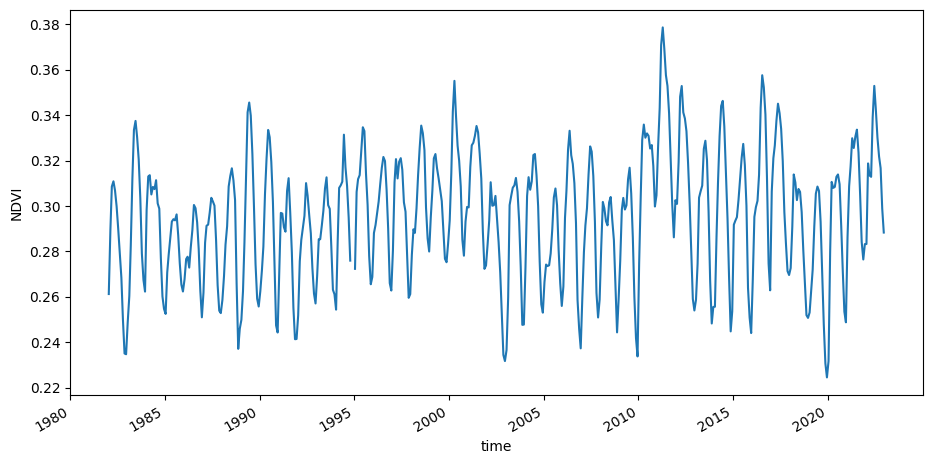

In [34]:
ds_interp.NDVI.mean(['latitude','longitude']).plot(figsize=(11,5))

## Step 4: keep interpolated data only where enough data existed

In [32]:
# ds_interp.NDVI.sel(time='2000').plot.imshow(col='time', robust=True, col_wrap=4)

In [35]:
#drop time-steps where fraction of pixels avail was less than 80 %
ds_interp_gaps = ds_interp.where(times_where_good_frac_data.drop('month'))

# replace dropped timesteps with the origianl gappy data
ds_interp_gaps = ds_interp_gaps.fillna(ds.sel(time=ds_interp.time))

#merge the interpolated data back with the modis data
ds_merged = xr.concat([ds_interp_gaps.sel(time=slice('1982','2000')),
                       ds.sel(time=slice('2001','2022'))],
                      dim='time').sortby('time')


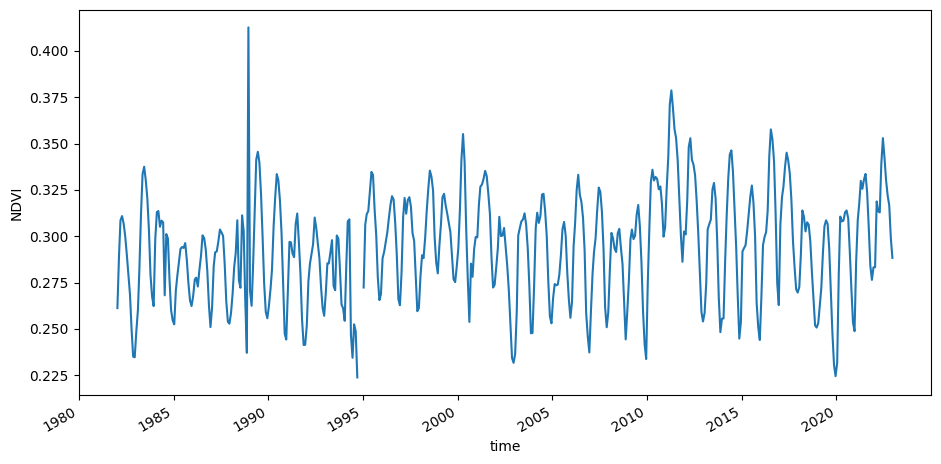

In [36]:
ds_interp_gaps.NDVI.mean(['latitude','longitude']).plot(figsize=(11,5))

## Step 5: Fill remaining data gaps with ML modelled NDVI

In [37]:
ml = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/results/ml_predictions/NDVI_predicted_5km_monthly_1982_2022.nc')
ml = ml.rename({'x':'longitude', 'y':'latitude'})

In [38]:
ds_final = ds_merged.fillna(ml)

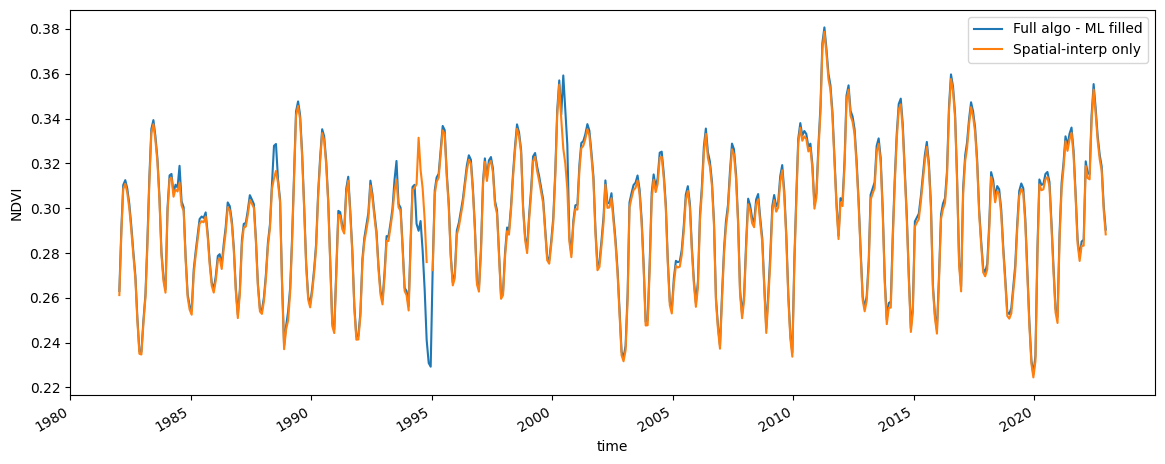

In [42]:
fig, ax = plt.subplots(1,1, figsize=(14,5))

ds_final.NDVI.mean(['latitude','longitude']).plot(ax=ax, label='Full algo - ML filled')

ds_interp.NDVI.mean(['latitude','longitude']).plot(ax=ax, label='Spatial-interp only')

# ds_interp_gaps.NDVI.mean(['latitude','longitude']).plot(ax=ax, label='Spatial interp with gaps')

ax.legend()

In [67]:
ds_interp_gaps.NDVI.sel(time='2000').plot.imshow(col='time', robust=True, col_wrap=6);

In [68]:
# ds_interp.NDVI.sel(time='2000').plot.imshow(col='time', robust=True, col_wrap=6);

In [69]:
# ds_final.NDVI.sel(time='2000').plot.imshow(col='time', robust=True, col_wrap=6);

In [49]:
ds_final.to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/NDVI_LGBM_5km_monthly_1982_2022_gapfilled_interp.nc')

In [53]:
_2000 = xr.open_dataarray('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/MODIS_NDVI_median_5km_monthly_2000.nc')

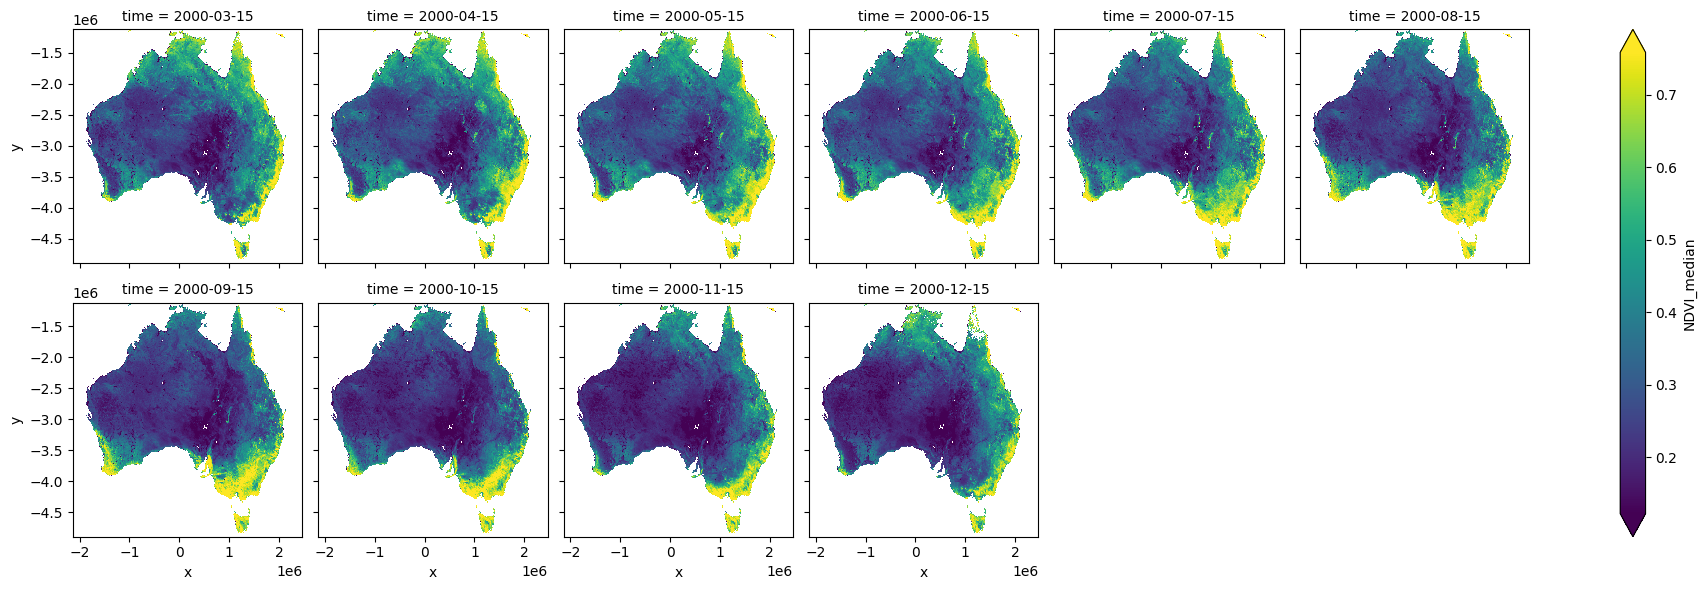

In [54]:
_2000.sel(time='2000').plot.imshow(col='time', robust=True, col_wrap=6);

In [70]:
syn_fill = ds.fillna(ml)

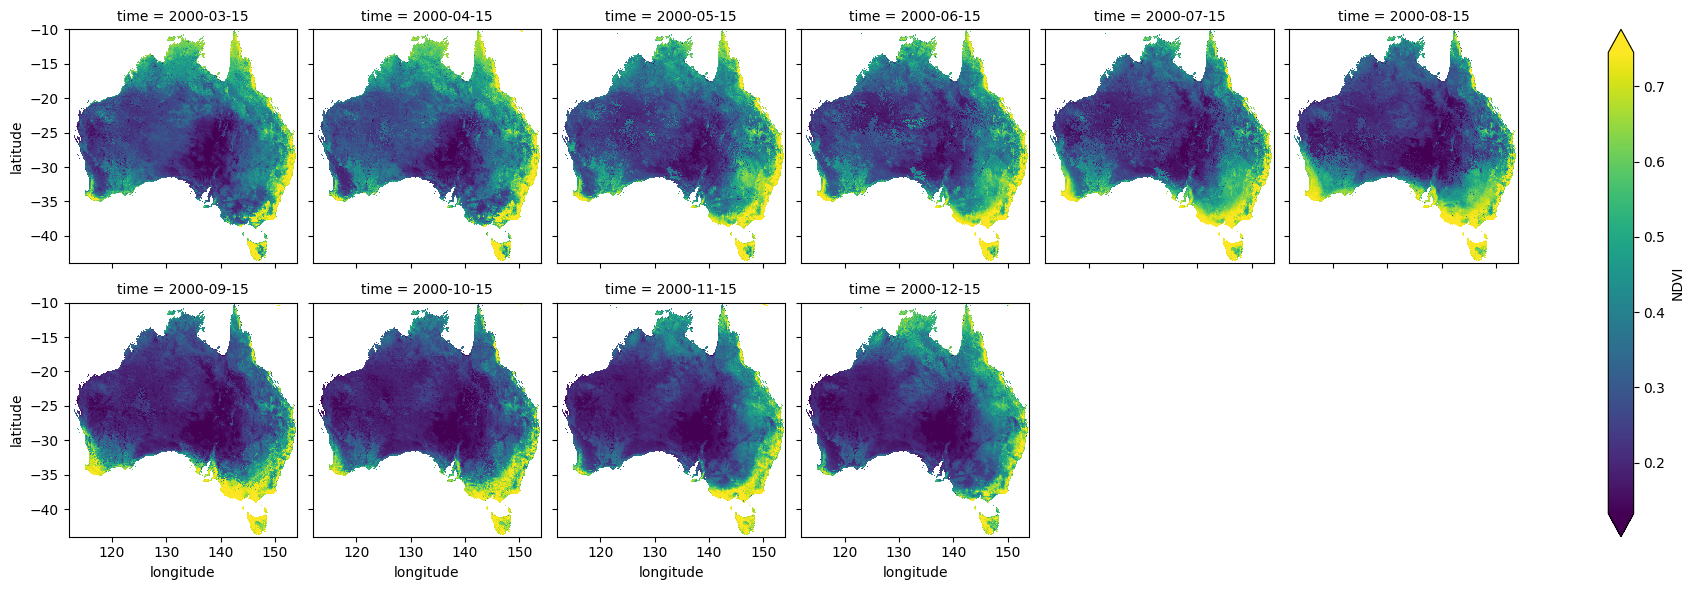

In [81]:
syn_fill.NDVI.sel(time=slice('2000-03','2000-12')).plot.imshow(col='time', robust=True, col_wrap=6);

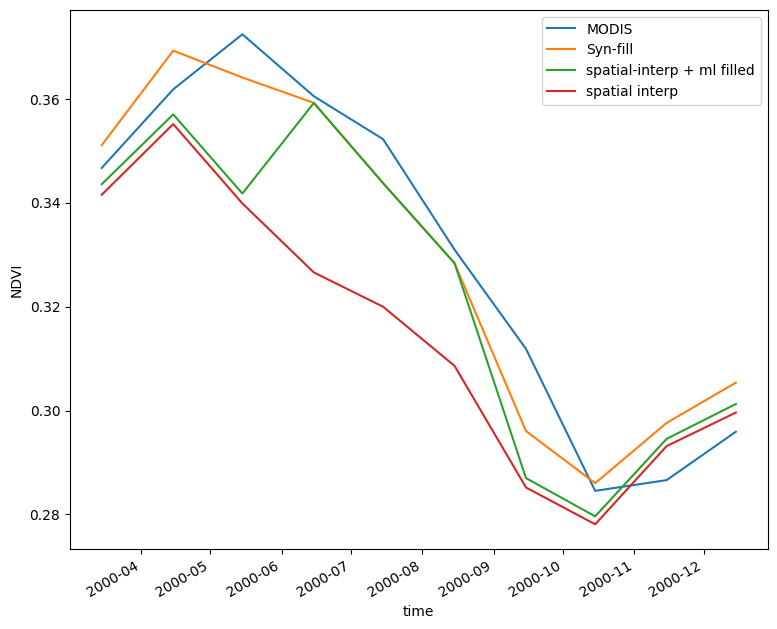

In [79]:
fig,ax = plt.subplots(1,1, figsize=(9,7))
_2000.mean(['x','y']).plot(ax=ax, label='MODIS')
syn_fill.NDVI.sel(time=slice('2000-03','2000-12')).mean(['longitude','latitude']).plot(ax=ax, label='Syn-fill')
ds_final.NDVI.sel(time=slice('2000-03','2000-12')).mean(['longitude','latitude']).plot(ax=ax, label='spatial-interp + ml filled')
ds_interp.NDVI.sel(time=slice('2000-03','2000-12')).mean(['longitude','latitude']).plot(ax=ax, label='spatial interp')
# ds_interp_gaps.NDVI.sel(time=slice('2000-03','2000-12')).mean(['longitude','latitude']).plot(ax=ax, label='spatial interp gaps')

ax.legend();